### Итоговый проект по фреймворку PyTorch для разработки искусственных нейронных сетей

In [1]:
import numpy as np
import pandas as pd
import mediapipe as mp

import glob
import cv2
import re

from google.protobuf.json_format import MessageToDict

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#### Обработка данных

In [2]:
files = glob.glob('./leapGestRecog/*/*/*')
len(files)

20000

In [3]:
def landmarks_to_df(landmarks, df=None, target=None):
    landmarks = MessageToDict(landmarks[0])['landmark']
    
    x = np.empty(len(landmarks))
    y = np.empty(len(landmarks))
    z = np.empty(len(landmarks))
    
    for i, v in enumerate(landmarks):
        x[i] = v['x']
        y[i] = v['y']
        z[i] = v['z']
    
    scaler = MinMaxScaler()
    
    x = scaler.fit_transform(x.reshape(-1, 1)).reshape(1, -1)
    y = scaler.fit_transform(y.reshape(-1, 1)).reshape(1, -1)
    z = scaler.fit_transform(z.reshape(-1, 1)).reshape(1, -1)
    
    if target is not None:
        features = np.c_[x, y, z, target]
    else:
        features = np.c_[x, y, z]
    
    if df is not None:
        df = pd.concat((df, pd.DataFrame(features)), axis=0)
    else:
        df = pd.DataFrame(features)
    
    return df

In [4]:
mapping = {'02': 1, '07': 2, '09': 3, '03': 4}
# Класс 1: 02 (l)
# Класс 2: 07 (ok)
# Класс 3: 09 (c)
# Класс 4: 03 (fist)
# К классу 0 будут отнесены остальные жесты

df = pd.DataFrame()

mp_hands = mp.solutions.hands

with mp_hands.Hands(max_num_hands=1, static_image_mode=True) as hands:
    for idx, file in enumerate(files):
        image = cv2.imread(file)
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if not results.multi_hand_landmarks:
            continue
            
        target = mapping.get(re.findall('frame_\d{2}_(\d{2})', file)[0], 0)
        df = landmarks_to_df(results.multi_hand_landmarks, df, target)

In [5]:
classes = df.iloc[:, -1]
classes.value_counts()

0.0    4531
2.0    1610
1.0    1000
4.0     520
3.0     118
Name: 63, dtype: int64

Итого имеем 4531 неизвестный жест, 1000 жестов, означающих указательный палец вверх, 1610 жестов, означающих "ок", 118 жестов, означающих букву "С", а также 520 жестов, означающих кулак. Довольно сбалансированное количество, если учесть искомые и неискомые жесты.

Теперь датасет можно сохранить, чтобы в дальнейшем загружаться с него для обучения модели и работы с приложением.

In [6]:
df.to_csv('./data.csv', index=False)
# df = pd.read_csv('./data.csv')
# df.columns = df.columns.astype(int)

#### Обучение

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], 
                                                    df.iloc[:, -1], 
                                                    random_state=41, 
                                                    test_size=0.25, 
                                                    stratify=classes, 
                                                    )

In [8]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [9]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1133
         1.0       0.98      0.97      0.98       250
         2.0       0.99      1.00      0.99       403
         3.0       0.97      1.00      0.98        29
         4.0       0.97      0.98      0.97       130

    accuracy                           0.99      1945
   macro avg       0.98      0.99      0.98      1945
weighted avg       0.99      0.99      0.99      1945



Метрики довольно высокие, классы разделяются хорошо.
Можно обучить модель на всём датасете и проверять работоспобность через приложение.

In [10]:
model.fit(df.iloc[:, :-1], df.iloc[:, -1]);

#### Разработка приложения

Установим, что система будет реагировать на жесты следующим образом:

Если класс 0, то на экране приложения будет появляться сообщение 'Неизвестный жест!';

Если класс 1, то на экране приложения будет появляться приветственное сообщение 'Привет!';

Если класс 2, то на экране приложения будет появляться сообщение 'Хорошо! и сохранится скриншот из программы MediaPipe Hands';

Если класс 3, то на экране приложения будет появляться сообщение 'Это буква С!';

Если класс 4, то приложение завершит работу, сохранится скриншот с последним кадром, а через print выведется сообщение 'Программа завершила работу!';

Если система поймёт, что за жест, но не уверена в его классе, то на экране будет появляться сообщение 'Не пойму класс!'.

In [11]:
cap = cv2.VideoCapture(0)

mp_face_detection = mp.solutions.face_detection

with mp_face_detection.FaceDetection() as face_detection:
    with mp_hands.Hands(max_num_hands=1) as hands:
        while cap.isOpened():
            success, image = cap.read()
            
            if not success:
                print('Ignoring empty camera frame!')
                continue

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = face_detection.process(image)

            if results.detections and MessageToDict(results.detections[0])['score'][0] > 0.85:
                results = hands.process(image)
                
                if results.multi_hand_landmarks:
                    gesture = model.predict_proba(landmarks_to_df(results.multi_hand_landmarks))[0]
                    
                    if max(gesture) > 0.5:
                        gesture = np.argmax(gesture)
                        
                        if gesture == 0:
                            text = 'Неизвестный жест!'
                            
                        elif gesture == 1:
                            text = 'Привет!'
                            
                        elif gesture == 2:
                            text = 'Хорошо!'
                            image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
                            cv2.imwrite('pic.png', image)
                            
                        elif gesture == 3:
                            text = 'Это буква С!'
                            
                        elif gesture == 4:
                            image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
                            cv2.imwrite('break.png', image)
                            print('Программа завершила работу!')
                            break
                            
                    else:
                        text = 'Не пойму класс!'
            
                    cv2.putText(image, text, (70, 50),
                                cv2.FONT_HERSHEY_COMPLEX,
                                1.5, (0, 0, 255), 2)
            
            else:
                cv2.putText(image, 'В кадре нет лица!', (70, 50),
                            cv2.FONT_HERSHEY_COMPLEX,
                            1.5, (0, 0, 255), 2)
            
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            cv2.imshow('MediaPipe Hands', image)
            
            if cv2.waitKey(5) & 0xFF == 27:
                break

cap.release()
cv2.destroyAllWindows()

Программа завершила работу!


#### Тестирование приложения

В кадре нет лица:

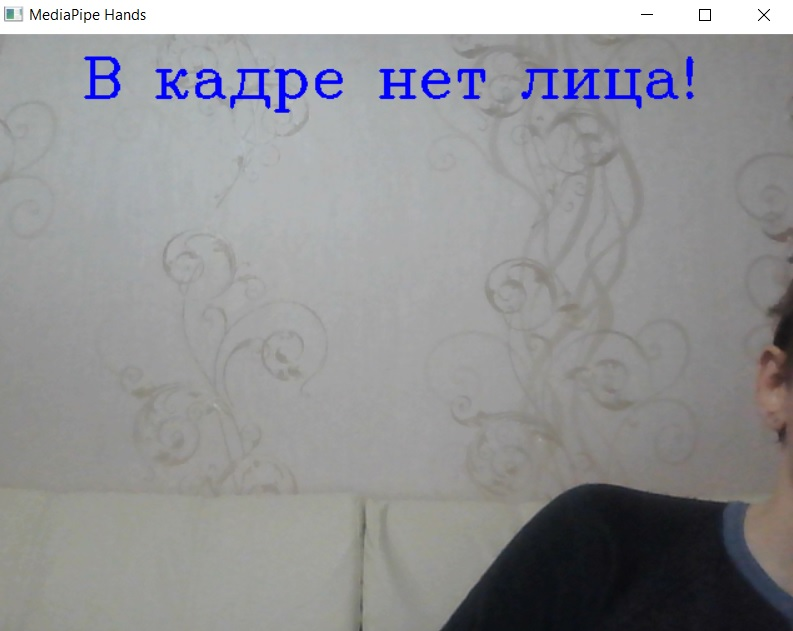

Когда система поняла, какой именно жест, но не определила класс:

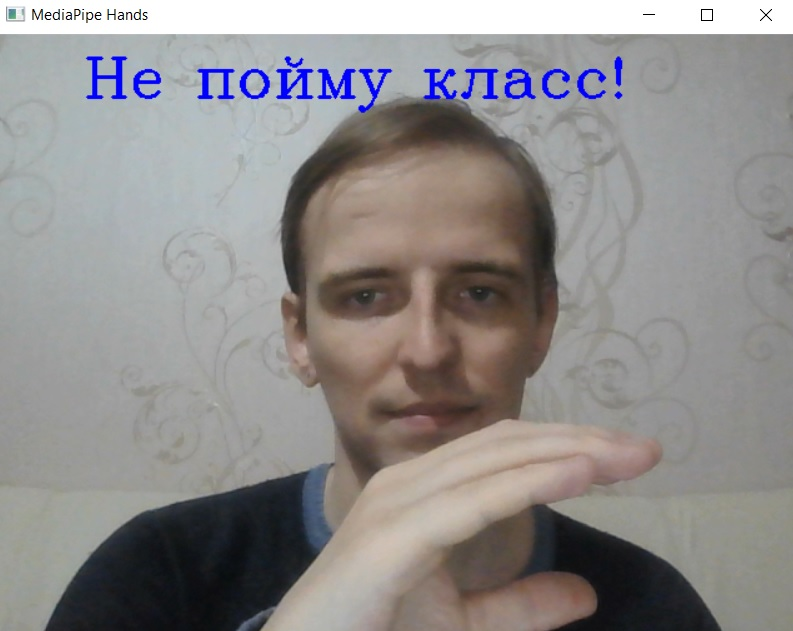

Класс 0 (неизвестный жест):

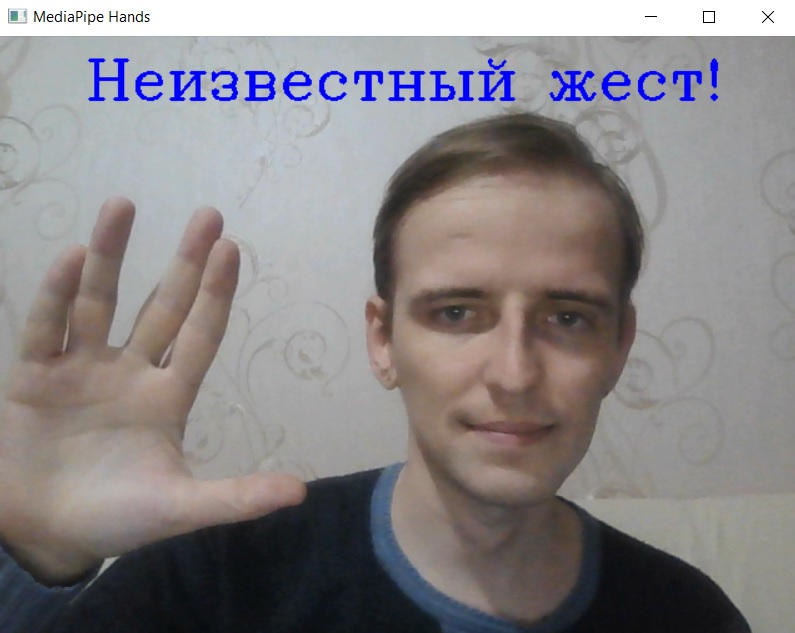

Класс 1 (указательный палец вверх, приветствие):

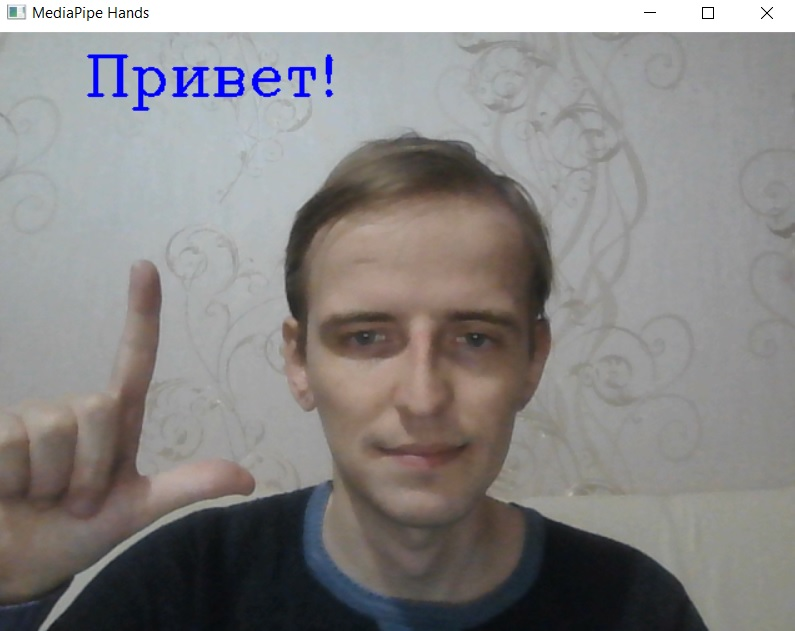

Класс 2 (жест "ок"):

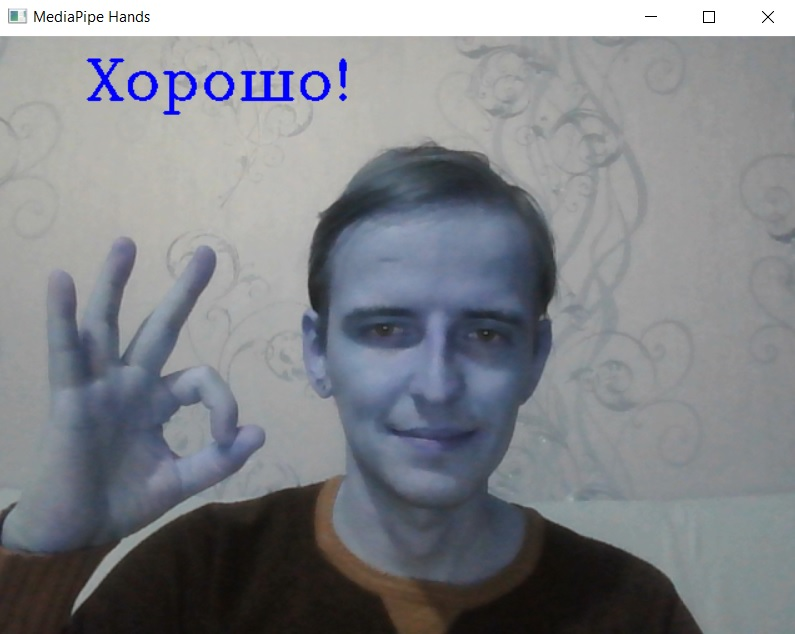

Класс 3 (жест с буквой "С"):

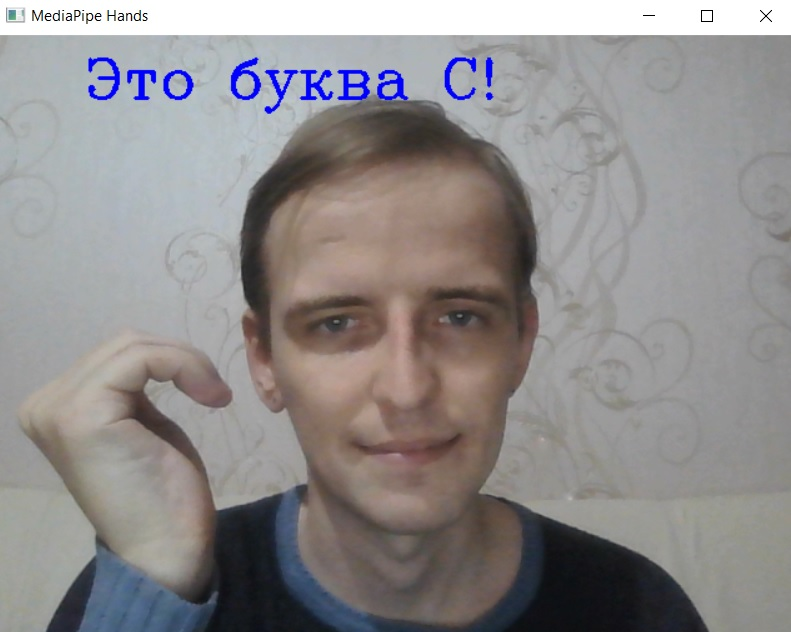